In [1]:
from music21 import stream, interval, corpus, converter, instrument, metadata
from music21 import note, chord, environment, duration, clef, pitch, key
from music21 import Music21Object, metadata
from music21.stream import Score
from music21.stream import Part
from music21.stream import Measure
import notebook
import copy
import json
from datetime import date, timedelta
import pandas as pd
import pathlib
import importlib
import numpy as np

In [2]:
class Instruments(object):
    """Encapsulates instrument information for the instruments supported by this framework:
       * music21 module
       * associated music21 class and class instance
       * range of the instrument - (low,high) as pitches
       * pitchRange - (low,high) as pitch pitch space attribute
       * Clef to use
       * transposeDiatonic
       * transposeChromatic
       * transposeText

    Instrument information maintained in resources/music/instruments.json
    Clef information in resources/music/clefs.json

    """
    
    instrument_names=[ 'Alto', 'Bass', 'Bassoon', 'Clarinet', 'Flute', 'Harpsichord', 'Koto', 'Oboe', 'Piano', 'PianoLH', 'PianoRH', 'Soprano', 'Tenor']
    clef_names=['Soprano', 'Alto', 'Tenor', 'Bass', 'Treble', 'Treble8va', 'Treble8vb', 'Bass8va', 'Bass8vb', 'C', 'F', 'G']
    
    def __init__(self, verbose=0, resource_folder ="/Compile/dwbzen/resources/music"):
        self.resource_folder = resource_folder
        self.verbose = verbose
        self.__create_instrument_classes()
        self.__create_clef_classes()

    @staticmethod
    def __create_instance(row:pd.Series) -> Music21Object:
        """Create an instance of a given class.
        
            Args:
                row - a pd.Series that has ''module' and 'class' members
            Returns:
                a module.class instance
        
        """
        module = row['module']
        class_name = row['class']
        my_module = importlib.import_module(module)
        MyClass = getattr(my_module, class_name)
        instance = MyClass()
        return instance
    
    @staticmethod
    def __define_pitch_range(row:pd.Series):
        notes = row['range'].split(",")
        nlow = note.Note(notes[0])
        nhigh = note.Note(notes[1])
        rlow = int(nlow.pitch.ps)
        rhigh = int(nhigh.pitch.ps)
        return [rlow,rhigh]
    
    def __create_instrument_classes(self):
        self.instruments_pd = pd.read_json(self.resource_folder + "/instruments.json", orient="index")
        self.instruments_pd['instance'] = [Instruments.__create_instance(row[1]) for row in self.instruments_pd.iterrows()]
        self.instruments_pd['range_ps'] = [Instruments.__define_pitch_range(row[1]) for row in self.instruments_pd.iterrows()]
        self.instruments_pd.fillna(value={'transposeDiatonic':0}, inplace=True)
        self.instruments_pd.fillna(value={'transposeChromatic':0}, inplace=True)
        self.instruments_pd.fillna(value={'transposeText':'Non-transposing'}, inplace=True)
    
    def __create_clef_classes(self):
        self.clefs_pd = pd.read_json(self.resource_folder + "/clefs.json", orient="index")
        self.clefs_pd['instance'] = [Instruments.__create_instance(row[1]) for row in self.clefs_pd.iterrows()]

    def get_clef(self, clef_name) -> clef.Clef:
        instance = None
        if clef_name in self.clefs_pd.index:
            instance = self.clefs_pd.loc[clef_name]['instance']
        return instance
    
    def get_instrument_clef(self, instrument_name) -> clef.Clef:
        instance = None
        if instrument_name in self.instruments_pd.index:
            clef_name = self.instruments_pd.loc[instrument_name]['clef']
            instance = self.get_clef(clef_name)
        return instance
    
    def get_instrument(self, instrument_name) -> instrument.Instrument:
        instance = None
        if instrument_name in self.instruments_pd.index:
            instance = self.instruments_pd.loc[instrument_name]['instance']
        return instance
    
    def is_in_range(self, instrument_name:str, note:note.Note) -> bool:
        """Return True if a Note is in the rage of a given Instrument, False otherwise
        
        """
        noteps = note.pitch.ps
        rng = self.instruments_pd.loc[instrument_name]['range_ps']
        inrange = (noteps >= rng[0] and noteps <= rng[1])
        return inrange
    
    def check_range(self, instrument_name:str, note:note.Note) -> int:
        """Returns the number of steps a Note is for a given Instrument, 0 otherwise.
        
            Args:
                instrument_name - the name of a supported Insturment
                note - the Note to test
            Returns:
                0 if in range
                if not in range, the #steps (semitones) the note is beyond the range.
                If <0, the Note is below by that number of steps
                If >0 the note is above by that number of steps
        
        """
        steps_out_of_range = 0
        noteps = note.pitch.ps
        rng = self.instruments_pd.loc[instrument_name]['range_ps']
        if noteps < rng[0]:
            steps_out_of_range = noteps - rng[0]
        elif noteps > rng[1]:
            steps_out_of_range = noteps - rng[1]
        return int(steps_out_of_range)
    
    def adjust_to_range(self, instrument_name:str, anote:note.Note, inPlace=False) -> note.Note:
        """Adjust the pitch of a Note if out of range.
            If below the instrument range, the note is transposed up an octave.
            If above the instrument range, the note is transposed down an octave.
        
            Args:
                instrument_name - the name of a supported Insturment
                note - the Note to test and possibly transpose
            Returns:
                a new note that is in range. If inPlace is True, the note provided is transposed in place.
        
        """
        steps_out_of_range = self.check_range(instrument_name, anote)
        #
        # if the note is out of range for this part (instrument)
        # transpose up an octave is below the range, down an octave if above
        if self.verbose > 0:
            print(f"newnote: {anote.nameWithOctave} out of range for {instrument_name}, by {steps_out_of_range} steps")
        if steps_out_of_range <0:
            tintval = interval.Interval('P8')
        elif steps_out_of_range < 0:
            tintval = interval.Interval('P-8')
        else:
            tintval = interval.Interval(0)
        #
        # transpose does not return a value if inPlace == True
        #
        if inPlace:
            anote.transpose(tintval, inPlace=True)
            return anote
        else:
            newnote = anote.transpose(tintval, inPlace=False)
            return newnote
 

In [3]:
class Utils(object):
    """Music utilities
    
    """
    
    verbose = 0
    C_Major = key.Key('C')
        
    @staticmethod
    def get_score(self, file_path:str) -> stream.Score:
        score = None
        file_info = music.Utils.get_file_info(file_path)
        if file_info['exists']:
                score = converter.parse(file_info['path_text'])
        return score
    
    #
    # get intervals for a Part
    #
    @staticmethod
    def get_part_intervals(apart:stream.Part) -> [dict]:
        intrvals = []
        part_notes = apart.flat.getElementsByClass('Note')
        for ind in range(len(part_notes)-1):
            n1 = part_notes[ind]
            n2 = part_notes[ind+1]
            i = interval.Interval(n1, n2)
            idict = {'note1':n1, 'note2':n2, 'interval':i}
            intrvals.append(idict)
        return intrvals
    
    @staticmethod
    def get_part_notes(apart:stream.Part) -> [note.Note]:
        part_notes = apart.flat.getElementsByClass('Note')
        return part_notes
    
    @staticmethod
    def get_score_intervals(ascore:stream.Score, partname:str=None) -> dict:
        """ Get the intervals for all Parts of a Score as a dict
        
        """
        parts = ascore.getElementsByClass(stream.Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                pdict[pname] = Utils.get_part_intervals(p)
        return pdict
    
    @staticmethod
    def get_score_notes(ascore:stream.Score, partname:str=None) -> dict:
        """Get the Notes for all Parts or the named part of a Score as a dict
        
        Note that this does not return Rest or Chord objects
        """
        parts = ascore.getElementsByClass(stream.Part)
        pdict = dict()
        for p in parts:
            pname = p.partName
            if partname is None or pname==partname:
                notes = Utils.get_part_notes(p)
                pdict[pname] = notes
        return pdict

    @staticmethod
    def get_music21_objects_for_score(classinfo, ascore:stream.Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,[str],[int]):
        if classinfo is note.Note:
            return Utils.get_notes_for_score(ascore, partnames, partnumbers)
        elif classinfo is interval.Interval:
            return Utils.get_intervals_for_score(ascore, partnames, partnumbers)
        else:
            raise TypeError
    
    @staticmethod
    def get_intervals_for_score(ascore:stream.Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,[str],[int]):
        """Get the intervals of all Parts of a Score as a pandas.DataFrame
        
        DataFrame columns returned:
            interval  (interval.Interval)
            part_name
            part_number
            note1  (note.Note the first Note in the interval pair)
            note2  (note.Note the second Note in the interval pair)
            name (interval name as in "P5")
            directedName  (as in "P-5" for down a 5th)
            niceName
            semitones (int)
        
        Returns a 3-tuplet consisting of the intervals_df DataFrame,
        a [int] of part numbers, and a [str] of part names.
        """
        pdict = Utils.get_score_intervals(ascore)
        intrvals_df = pd.DataFrame()
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        for k in pdict.keys():  # part names
                if (partnames is None or len(partnames)==0 or k in partnames) or (partnumbers is None or len(partnumbers)==0 or part_number in partnumbers):
                    part_intervals = pdict[k]
                    intervals =  [x['interval'] for x in part_intervals]
                    df = pd.DataFrame(data=intervals, columns=['interval'])
                    df['part_number'] = part_number
                    df['part_name'] = k
                    df['note1'] = [x['note1'] for x in part_intervals]
                    df['note2'] = [x['note2'] for x in part_intervals]
                    score_partnames.add(k)
                    score_partnumbers.add(part_number)
                    intrvals_df = intrvals_df.append(df)
                    part_number = part_number + 1
    
        intrvals_df['name'] = [x.name for x in intrvals_df['interval']]
        intrvals_df['directedName'] = [x.directedName for x in intrvals_df['interval']]
        intrvals_df['niceName'] = [x.niceName for x in intrvals_df['interval']]
        intrvals_df['semitones'] = [x.semitones for x in intrvals_df['interval']]
        return intrvals_df, score_partnames, score_partnumbers
    

    @staticmethod
    def get_notes_for_score(ascore:stream.Score, partnames:[str]=None, partnumbers:[int]=None) ->  (pd.DataFrame,[str],[int]):
        """Get the Notes of all Parts from a score as a pandas.DataFrame
        
        DataFrame columns returned:
            part_name
            part_number
            Note (music21.note.Note)
            name
            nameWithOctave
            pitch (music21.pitch.Pitch)
            duration (music21.duration.Duration)
            pitchClass (int)
        
        Returns a 3-tuple consisting of the notes_df DataFrame,
        an integer list of part numbers, and a str list of part names.
        """
        pdict = Utils.get_score_notes(ascore)
        notes_df = pd.DataFrame()
        part_number = 1
        score_partnames = set()
        score_partnumbers = set()
        for k in pdict.keys():
            if (partnames is None or k in partnames) or (partnumbers is None or part_number in partnumbers):
                df = pd.DataFrame(data=pdict[k], columns=['note'])
                df['part_number'] = part_number
                df['part_name'] = k
                score_partnames.add(k)
                score_partnumbers.add(part_number)
                notes_df = notes_df.append(df)
                part_number = part_number + 1
        
        notes_df['name'] = [x.name for x in notes_df['note']]
        notes_df['nameWithOctave'] = [x.nameWithOctave for x in notes_df['note']]
        notes_df['pitch'] = [x.pitch for x in notes_df['note']]
        notes_df['duration'] = [x.duration for x in notes_df['note']]
        notes_df['pitchClass'] = [x.pitch.pitchClass for x in notes_df['note']]
        notes_df.reset_index(drop=True, inplace=True)
        return notes_df, score_partnames, score_partnumbers
    
    @staticmethod
    def get_durations_from_notes(source_df:pd.DataFrame) -> pd.DataFrame:

        """Get the Durations from a notes or intervals DataFrame
        
        The notes_df argument has the columns described in get_notes_for_score().
        DataFrame columns returned:
            note (music21.note.Note)
            duration (music21.duration.Duration)
            type
            ordinal
            dots
            fullName
            quarterLength
            tuplets
        See the music21.duration documentation for details on individual fields
        """
        if 'duration' in source_df.columns:
            notes_df = source_df
            durations_df = pd.DataFrame(data=notes_df[['note','duration']], columns=['note','duration'])
            durations_df['type'] = [x.type for x in notes_df['duration']]
            durations_df['ordinal'] = [x.ordinal for x in notes_df['duration']]
            durations_df['dots'] = [x.dots for x in notes_df['duration']]
            durations_df['fullName'] = [x.fullName for x in notes_df['duration']]
            durations_df['quarterLength'] = [x.quarterLength for x in notes_df['duration']]
            durations_df['tuplets'] = [x.tuplets for x in notes_df['duration']]
        else:
            intervals_df = source_df
            durations_df = pd.DataFrame(data=intervals_df[['note1']], columns=['note1'])
            durations_df['duration'] = [x.duration for x in intervals_df['note1']]
            durations_df['type'] = [x.duration.type for x in intervals_df['note1']]
            durations_df['ordinal'] = [x.duration.ordinal for x in intervals_df['note1']]
            durations_df['dots'] = [x.duration.dots for x in intervals_df['note1']]
            durations_df['fullName'] = [x.duration.fullName for x in intervals_df['note1']]
            durations_df['quarterLength'] = [x.duration.quarterLength for x in intervals_df['note1']]
            durations_df['tuplets'] = [x.duration.tuplets for x in intervals_df['note1']]
            durations_df.rename(columns={'note1':'note'}, inplace=True)
        return durations_df
    
    @staticmethod
    def get_metadata_bundle(composer:str=None, title:str=None) -> metadata.bundles.MetadataBundle:
        meta = None
        if composer is not None:
            meta = corpus.search(composer,'composer')
            if title is not None:
                meta = meta.intersection(corpus.search(title,'title'))
        elif title is not None:
            meta = corpus.search(title,'title')
        return meta
    
    @staticmethod
    def get_all_score_music21_objects(classinfo, composer=None, title=None, partnames=None, partnumbers=None):
        if classinfo is note.Note:
            return Utils.get_all_score_notes(composer, title, partnames, partnumbers)
        elif classinfo is interval.Interval:
            return Utils.get_all_score_intervals(composer, title, partnames, partnumbers)
        else:
            raise TypeError
        
    @staticmethod
    def get_all_score_intervals(composer=None, title=None, partnames=None, partnumbers=None):
        meta = Utils.get_metadata_bundle(composer, title)
        intrvals_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            score = corpus.parse(meta[i])
            df,pnames,pnums = Utils.get_intervals_for_score(score, partnames, partnumbers)
            df['title'] = md.title
            intrvals_df = intrvals_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return intrvals_df, all_score_partnames, all_score_partnumbers
    
    @staticmethod
    def get_all_score_notes(composer=None, title=None, partnames=None, partnumbers=None):
        meta = Utils.get_metadata_bundle(composer, title)
        notes_df = pd.DataFrame()
        all_score_partnames = set()
        all_score_partnumbers = set()
        for i in range(len(meta)):
            md = meta[i].metadata
            score = corpus.parse(meta[i])
            df,pnames,pnums = Utils.get_notes_for_score(score, partnames, partnumbers)
            df['title'] = md.title
            notes_df = notes_df.append(df)
            all_score_partnames = all_score_partnames.union(pnames)
            all_score_partnumbers = all_score_partnumbers.union(pnums)
        return notes_df, all_score_partnames, all_score_partnumbers
    
    @staticmethod
    def show_measures(measures, how='text'):
        nmeasures = len(measures)
        print(f"number of measures: {nmeasures}")
        i = 1
        for measure in measures:
            notes = measure.getElementsByClass(['Note','Chord','Rest'])
            print('measure {}'.format(i))
            for n in notes:
                if n.isNote:
                    print(n.nameWithOctave)
                else:
                    print(n.fullName)
            i = i+1
            measure.show(how)   # if None, displays in MuseScore
    
    @staticmethod
    def show_intervals(df, what='name') -> pd.DataFrame:
        int_string = str(df[what].values.tolist())
        return int_string
    
    @staticmethod
    def show_notes(df, what='name') -> pd.DataFrame:
        note_string = str(df[what].values.tolist())
        return note_string
    
    @staticmethod
    def show_durations(df, what='quarterLength'):
        duration_string = str(df[what].values.tolist())
        return duration_string
    
    @staticmethod
    def note_info(note):
        dur = note.duration
        if note.isRest:
            info = f'name: {note.name}, fullName: {note.fullName}, type: {dur.type}, dots: {dur.dots},\
            quarterLength: {dur.quarterLength}'
        else:
            info = f'{note.nameWithOctave}, type: {dur.type}, dots: {dur.dots},\
            fullName: {dur.fullName}, quarterLength: {dur.quarterLength}, tuplets: {dur.tuplets}'
        return info

    @staticmethod
    def duration_info(dur) -> duration.Duration:
        info = f'type: {dur.type}, ordinal: {dur.ordinal}, dots: {dur.dots}, fullName: {dur.fullName}, \
        quarterLength {dur.quarterLength}, tuplets: {dur.tuplets}'
        return info
    
    @staticmethod
    def get_interval_stats(ascore, partnames=None, partnumbers=None):
        int_df,pnames,pnums = Utils.get_intervals_for_score(ascore, partnames, partnumbers)
        int_df = int_df.groupby(by=['semitones']).count()[['interval']]
        int_df.rename(columns={'interval':'count'}, inplace=True)
        int_df.reset_index(inplace=True)       
        return int_df.sort_values(by='count', ascending=False)

    @staticmethod
    def create_note(start_note:note.Note, 
                    anInterval:interval.Interval=None, semitones:int=None,
                    dur:duration.Duration=None, quarterLen:int=None) -> note.Note:
        """Creates a new Note a given interval away from a starting note
        
        Args:
            start_note (note.Note): the anchor Note
            interval (interval.Interval): a valid Interval or None. If None, semitones must be present.
            semitones (int): interval expressed as semitones
            duration (duration.Duration): duration to assign to the new Note
            quarterLength (int): duration to assign to the new Note expressed as quarterLength
        Returns:
            A new Note that is the specified interval away from the start_note.
        Notes:
            * duration or quarterLength may be specified, but not both.
            * if both duration and quarterLength are none, the duration of the new Note
              will be the same as the duration of start_note
        """
        new_note = copy.copy(start_note)    # shallow copy
        if anInterval is None and semitones is None:
            raise ValueError('interval and semitones cannot both be None')
        intval = anInterval
        if anInterval is None:
            intval = interval.Interval(semitones)
        new_note = new_note.transpose(intval)
        if dur is None and quarterLen is not None:
            new_note.quarterLength = quarterLen
        elif dur is not None:
            new_note.duration = dur
        return new_note
    
    @staticmethod
    def random_notes(lower_ps:int, upper_ps:int, num:int=10, minval=0.5) -> [note.Note]:
        notes = []
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps values)
            dur = random.randrange(1, 8) * minval       # random durations as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        return notes
    
    @staticmethod
    def random_part(lower_ps:int, upper_ps:int, num:int=10, minval=0.5, 
                     clef=clef.TrebleClef(), instrument=instrument.Piano()):
        # minval is given as quarterLength, 0.5 is an eighth note, 0.25 is a 16th etc.
        part = stream.Part()
        part.insert(0,instrument)
        notes = []
        notes.append(clef)
        for n in range(num):
            ps = random.randrange(lower_ps,upper_ps)    # random pitch (ps value) c4 to b6
            dur = random.randrange(1, 8) * minval    # random durations (multiples of 16th notes) as quarterLength
            notes.append(note.Note(ps=ps, quarterLength=dur))
        part.append(notes)
        return part
    
    @staticmethod
    def get_file_info(cpath:str, def_extension:str='mxl') -> dict:
        """Breaks up a path name into component parts
        
        """
        
        known_extensions = [def_extension, 'mxl','.xml','.musicxml','.json','.txt','.csv']
        x = cpath.split("/")
        paths = x[0:len(x)-1]
        filename = x[-1]
        ext = filename.split(".")
        name = ext[0]
        if len(ext)==2 and ext[1] in known_extensions:
            ext = ext[1]
            path = cpath      
        else:
            ext = def_extension
            filename = f"{filename}.{ext}"
            path = f"{cpath}.{ext}"
        p = pathlib.Path(path)
        exists = p.exists()
        return  {'paths':paths, 'path_text':path, 'filename':filename, 'name':name,'extension': ext, 'Path':p, 'exists':exists}

    @staticmethod
    def round_values(x, places=5):
        if not type(x) is str:
            return round(x, places)
        else:
            return x
    
    @staticmethod
    def get_timedelta(start_date=date(1970,1,1), end_date=date.today()) -> int:
        """Gets the number of elapsed seconds between two dates.
        
        Args:
            start_date (datetime.date): the starting date. Default value is Jan 1,1970
            end_date: the ending date. Default value is today()
        Returns:
            The absolute value of the number of elapsed seconds between the two dates.
        Notes:
            Useful in setting a random seed.
        
        """
        
        delta = end_date - start_date
        return abs(int(delta.total_seconds()))
    
    @staticmethod
    def get_score_parts(aScore:stream.Score):
        """Get the Parts of a Score
        Args:
            aScore - a stream.Score instance
        Returns:
            A dict of stream.Part with the key partName
        
        """
        parts_dict = dict()
        if aScore is not None:
            parts = aScore.getElementsByClass(stream.Part)
            for p in parts:
                parts_dict[p.partName] = p
        return parts_dict
    
    @staticmethod
    def get_keySignatures(apart:stream.Part):
        """Gets the KeySignatures appearing in a given Part
        
            Args:
                apart : a stream.Part instance
            Returns:
                a tupple consisting of 2 lists:
                [KeySignature] in the order of appearance
                [int] of measure numbers where the KeySignature occurs
        """
        measures = apart.getElementsByClass(stream.Measure)
        key_sigs = []
        measure_numbers = []
        for m in measures:
            keys = m.getElementsByClass([key.Key,key.KeySignature])
            for k in keys:
                if k is not None:
                    key_sigs.append(k.asKey())
                    measure_numbers.append(m.measureNumber)
        return key_sigs,measure_numbers
    
    @staticmethod
    def get_transposition_intervals(keys:[key.Key], key2:key.Key=C_Major) -> [interval.Interval]:
        intval = []
        for akey in keys:
            k = akey.asKey()
            p1 = k.getPitches()[0]
            p2 = key2.getPitches()[0]
            if Utils.verbose > 1:
                print('transposition key pitches {}, {}'.format(p1.nameWithOctave,p2.nameWithOctave))
            intval.append(interval.Interval(noteStart = p1,noteEnd = p2))
        return intval

    @staticmethod
    def transpose_part(apart:Part, target_key=C_Major, instruments:Instruments=None, inPlace=False) -> Part:
            """Transpose the notes in a given Part
                Args:
                    apart : a stream.Part instance
                    target_key : the transposition Key. Default is C-Major if not specified
                    instruments - music.Instruments instance, if not None Part ranges are enforced after the transposition
                    inplace - if True, transpose in place. Otherwise transpose a copy
                Returns:
                    A Part with the notes transposed as specified.
                    The Part argument is not modified if inPlace is False.
            """
            key_sigs,measure_numbers = Utils.get_keySignatures(apart)
            measure_numbers.append(len(apart))
            transposition_intervals = Utils.get_transposition_intervals(key_sigs)
            transposed_part = apart
            if not inPlace:     # transpose a copy of the Part
                transposed_part = copy.deepcopy(apart)

            for i in range(len(transposition_intervals)):
                #
                # no need to transpose if the measures are already in the target_key
                #
                intval = transposition_intervals[i]
                if Utils.verbose > 0:
                    print(f"transposition interval: {intval}")
                if intval == target_key:
                    continue
                transposed_part.measures(measure_numbers[i], measure_numbers[i+1]-1).transpose(intval, inPlace=True)

            if instruments is not None:
                #
                # check if notes are in range for Instrument and adjust if necessary
                #
                for anote in transposed_part.flat.getElementsByClass('Note'):
                    instruments.adjust_to_range(apart.partName, anote, inPlace=True)

            return transposed_part

    @staticmethod
    def transpose_score(ascore:Score, target_key=C_Major,  partnames:[str]=None, instruments:Instruments=None, inPlace=False) -> stream.Score:
            """Transpose an entire Score to a new Key

                Args:
                    ascore - the Score to transpose
                    target_key - the new Key, default is C-Major
                    partnames - part names to include (and transpose)
                    instruments - music.Instruments instance, if not None Part ranges are enforced after the transposition
                    inplace - if True, transpose in place. Otherwise transpose a copy
                Returns:
                    a transposed Score. The original is not modified if inPlace is False

            """
            parts = ascore.getElementsByClass(Part)
            new_score = Score()
            for p in parts:
                pname = p.partName
                if partnames is None or pname in partnames:
                    if Utils.verbose > 0:
                        print('transpose {}'.format(pname))
                    tp = Utils.transpose_part(p, target_key=target_key, instruments=instruments, inPlace=inPlace)
                    new_score.append(tp)
            return new_score

In [4]:
test_score = corpus.parse('Collector_Test.mxl')
parts = test_score.getElementsByClass(stream.Part)
soprano_part = parts[0]
#soprano_part.show()

In [9]:
test_score.metadata.title

'Collector/Producer Test Score'

In [8]:
keysigs, measurenums = Utils.get_keySignatures(soprano_part)
print(keysigs)
print(measurenums)

[<music21.key.Key of B- major>, <music21.key.Key of D major>]
[1, 5]


In [9]:
# soprano_part.measures(1,4).show()

In [10]:
# soprano_part.measures(5, len(soprano_part)).show()

In [11]:
Utils.get_transposition_intervals(keysigs)

[<music21.interval.Interval m-7>, <music21.interval.Interval M-2>]

In [12]:
# Utils.get_music21_objects_for_score(score, partnames) calls: 
#  Utils.get_notes_for_score(score, partnames) calls:
#   Utils.get_score_notes(score) -> notes_df
#    Utils.get_score_notes(score, partname) -> {partname : [note.Note]}
#     Utils.get_part_notes(stream.Part) -> [note.Note] 
soprano_notes = Utils.get_part_notes(soprano_part)

In [7]:
part_measures =  soprano_part.measures(1, len(soprano_part))
measures = part_measures.getElementsByClass('Measure')
notes_df = pd.DataFrame()
for m in measures:
    num = m.number
    # print('measure: {} {}'.format(num, m))
    for n in m.notes:
        # print('note: {}'.format(n))
        d = {'measure': [num], 'note':[n]}
        df = pd.DataFrame(data=d)
        notes_df = notes_df.append(df)
notes_df.head()

,measure,note
0,1,<music21.note.Note D>
0,2,<music21.note.Note G>
0,2,<music21.note.Note F>
0,2,<music21.note.Note E->
0,2,<music21.note.Note D>


In [6]:
instruments = Instruments()

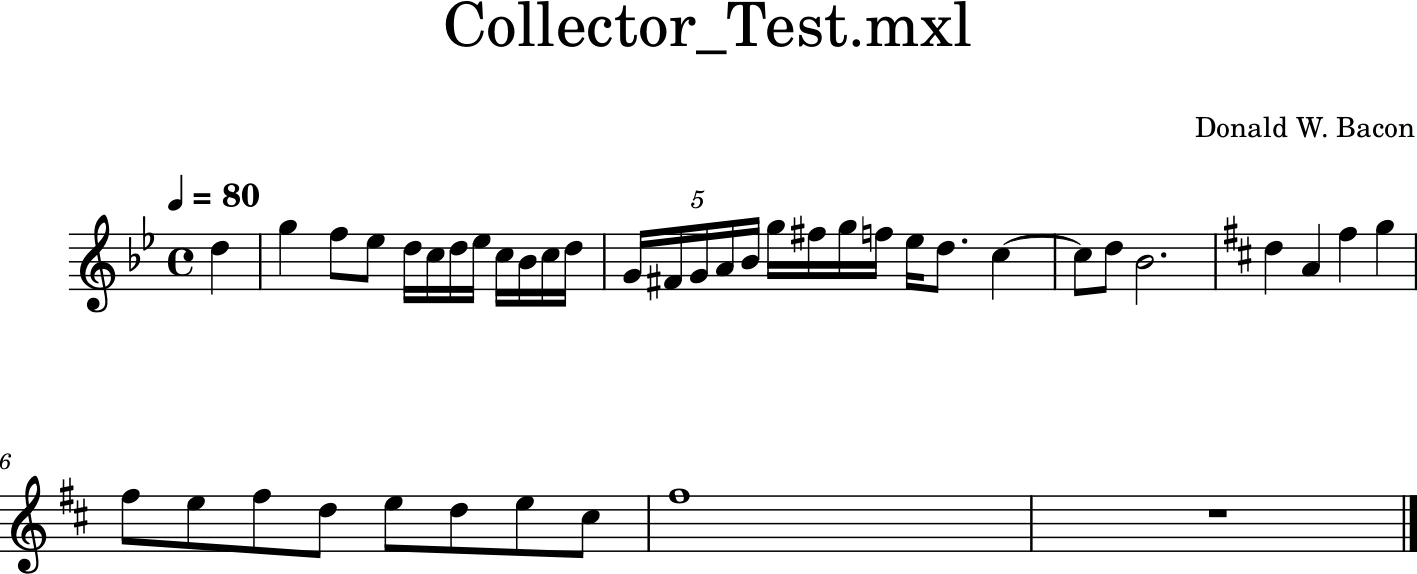

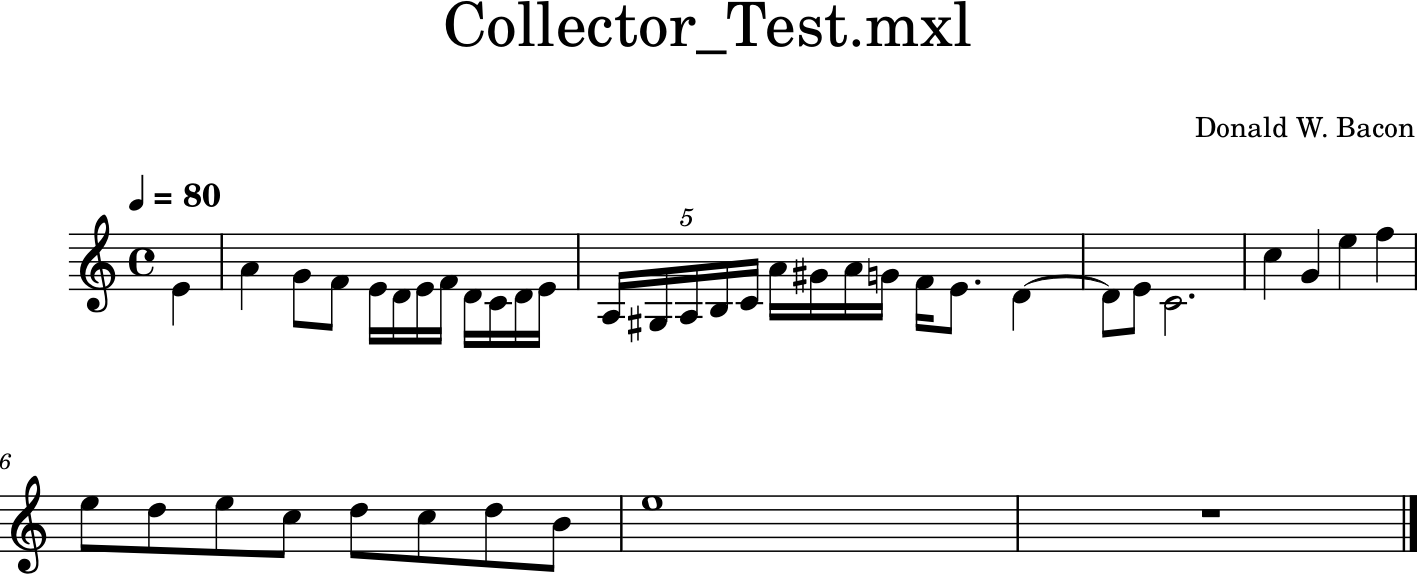

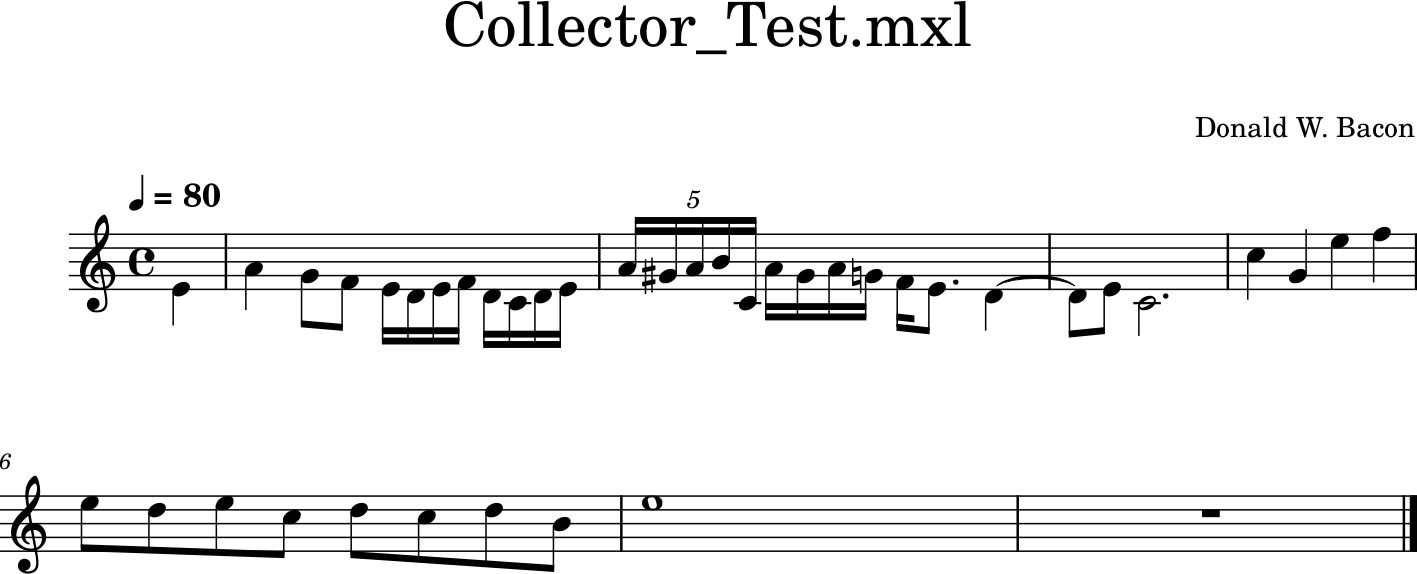

In [8]:
soprano_part.show()
sp = Utils.transpose_part(soprano_part)
sp.show()
#
# providing instruments forces range checking
# adjust any note that is out of range by transposing it 
# an octave up or down as needed
#
sp2 = Utils.transpose_part(soprano_part, instruments=instruments)
sp2.show()

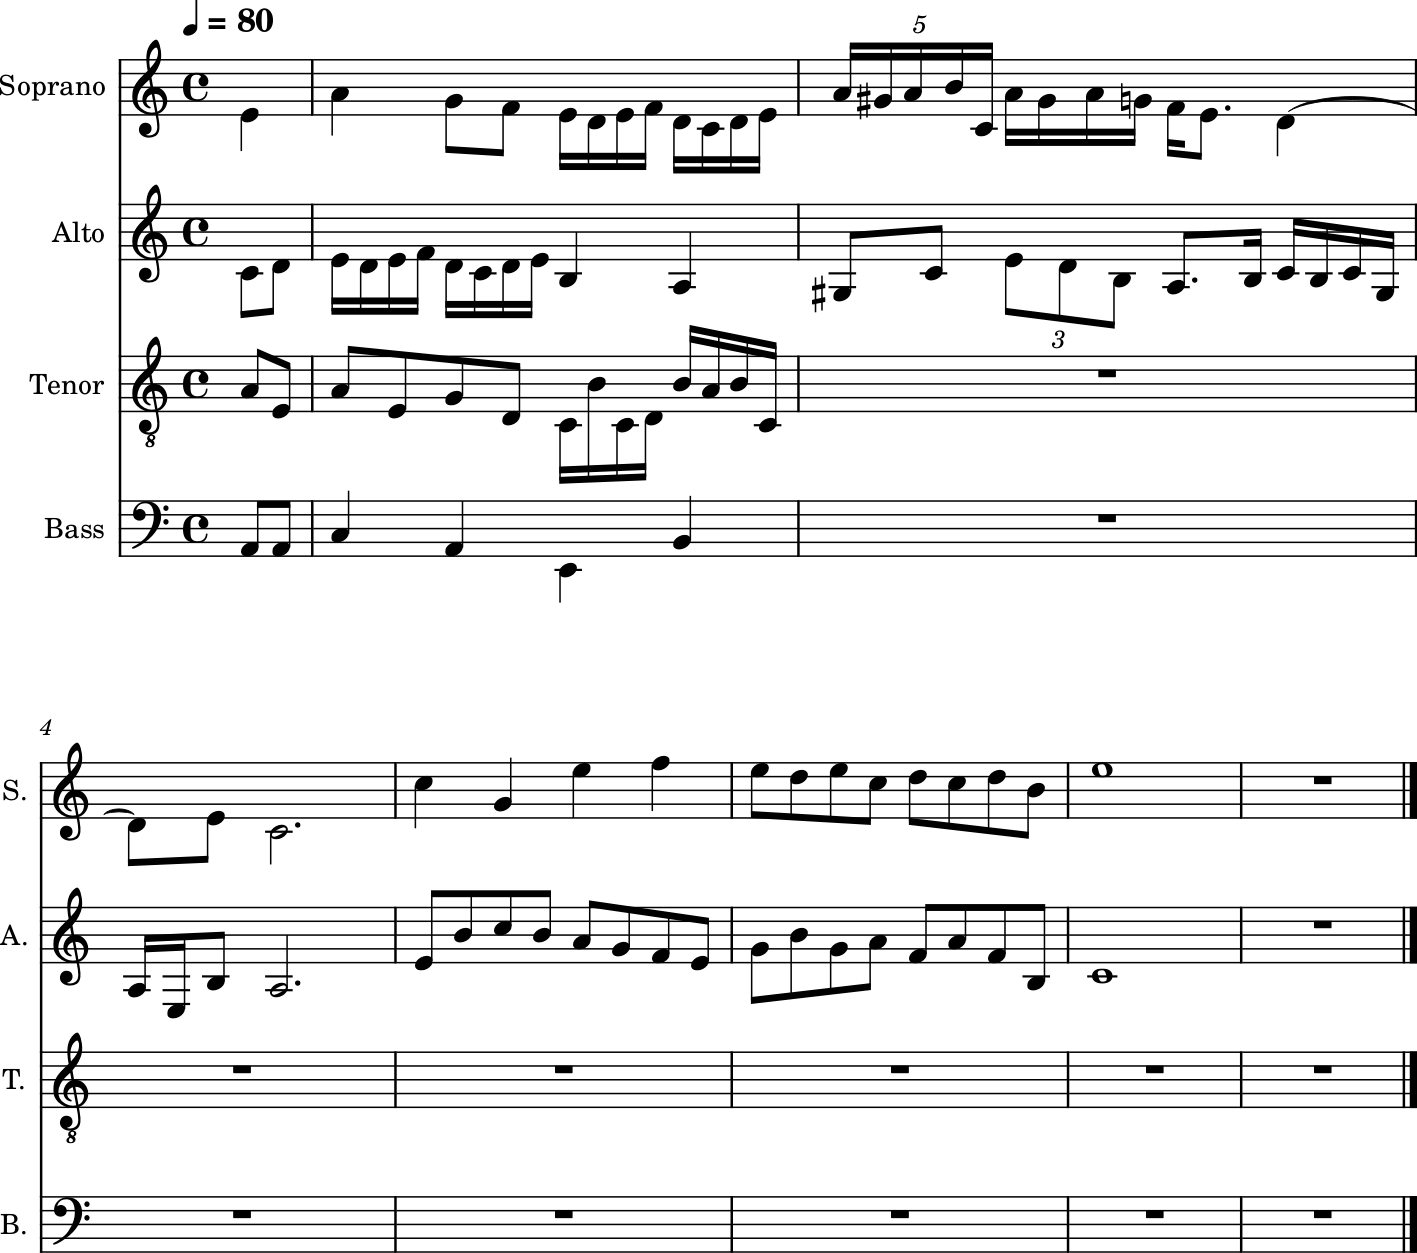

In [9]:
partnames=['Soprano','Alto','Tenor','Bass']
new_test_score = Utils.transpose_score(test_score, partnames, instruments=instruments)
new_test_score.show()

In [44]:
anote = note.Note("G5")
intval = interval.Interval('P8')
nnote = anote.transpose(intval, inPlace=False)    # does not return a value if inPlace is True
print(anote.nameWithOctave, nnote.nameWithOctave)

G5 G6


In [37]:
notes_df, score_partnames, score_partnumbers = Utils.get_notes_for_score(new_test_score, partnames)

In [38]:
notes_df

,note,part_number,part_name,name,nameWithOctave,pitch,duration,pitchClass
0,<music21.note.Note E>,1,Soprano,E,E4,E4,<music21.duration.Duration 1.0>,4
1,<music21.note.Note A>,1,Soprano,A,A4,A4,<music21.duration.Duration 1.0>,9
2,<music21.note.Note G>,1,Soprano,G,G4,G4,<music21.duration.Duration 0.5>,7
3,<music21.note.Note F>,1,Soprano,F,F4,F4,<music21.duration.Duration 0.5>,5
4,<music21.note.Note E>,1,Soprano,E,E4,E4,<music21.duration.Duration 0.25>,4
...,...,...,...,...,...,...,...,...
1,<music21.note.Note A>,4,Bass,A,A2,A2,<music21.duration.Duration 0.5>,9
2,<music21.note.Note C>,4,Bass,C,C3,C3,<music21.duration.Duration 1.0>,0
3,<music21.note.Note A>,4,Bass,A,A2,A2,<music21.duration.Duration 1.0>,9
4,<music21.note.Note E>,4,Bass,E,E2,E2,<music21.duration.Duration 1.0>,4


In [39]:
partNotes_df = notes_df[notes_df['part_name']=='Soprano']
partNotes_df.head()

,note,part_number,part_name,name,nameWithOctave,pitch,duration,pitchClass
0,<music21.note.Note E>,1,Soprano,E,E4,E4,<music21.duration.Duration 1.0>,4
1,<music21.note.Note A>,1,Soprano,A,A4,A4,<music21.duration.Duration 1.0>,9
2,<music21.note.Note G>,1,Soprano,G,G4,G4,<music21.duration.Duration 0.5>,7
3,<music21.note.Note F>,1,Soprano,F,F4,F4,<music21.duration.Duration 0.5>,5
4,<music21.note.Note E>,1,Soprano,E,E4,E4,<music21.duration.Duration 0.25>,4


In [85]:
notes_df, score_partnames, score_partnumbers = Utils.get_notes_for_score(new_test_score, partnames)
filename = "/Compile/dwbzen/resources/music/collector_test_notes_df.json"
notes_dfx = notes_df[['name','nameWithOctave','pitchClass']]
result = notes_dfx.to_json(orient='records')
parsed = json.loads(result)
dumped = json.dumps(parsed, indent=4)
with open(filename, 'w') as f:
    f.write(str(dumped))

In [84]:
notes_df, score_partnames, score_partnumbers = Utils.get_notes_for_score(new_test_score, partnames)
filename = "/Compile/dwbzen/resources/music/collector_test_notes_df.csv"
notes_dfx = notes_df[['name','nameWithOctave','pitchClass']]
notes_dfx.to_csv(path_or_buf=filename)

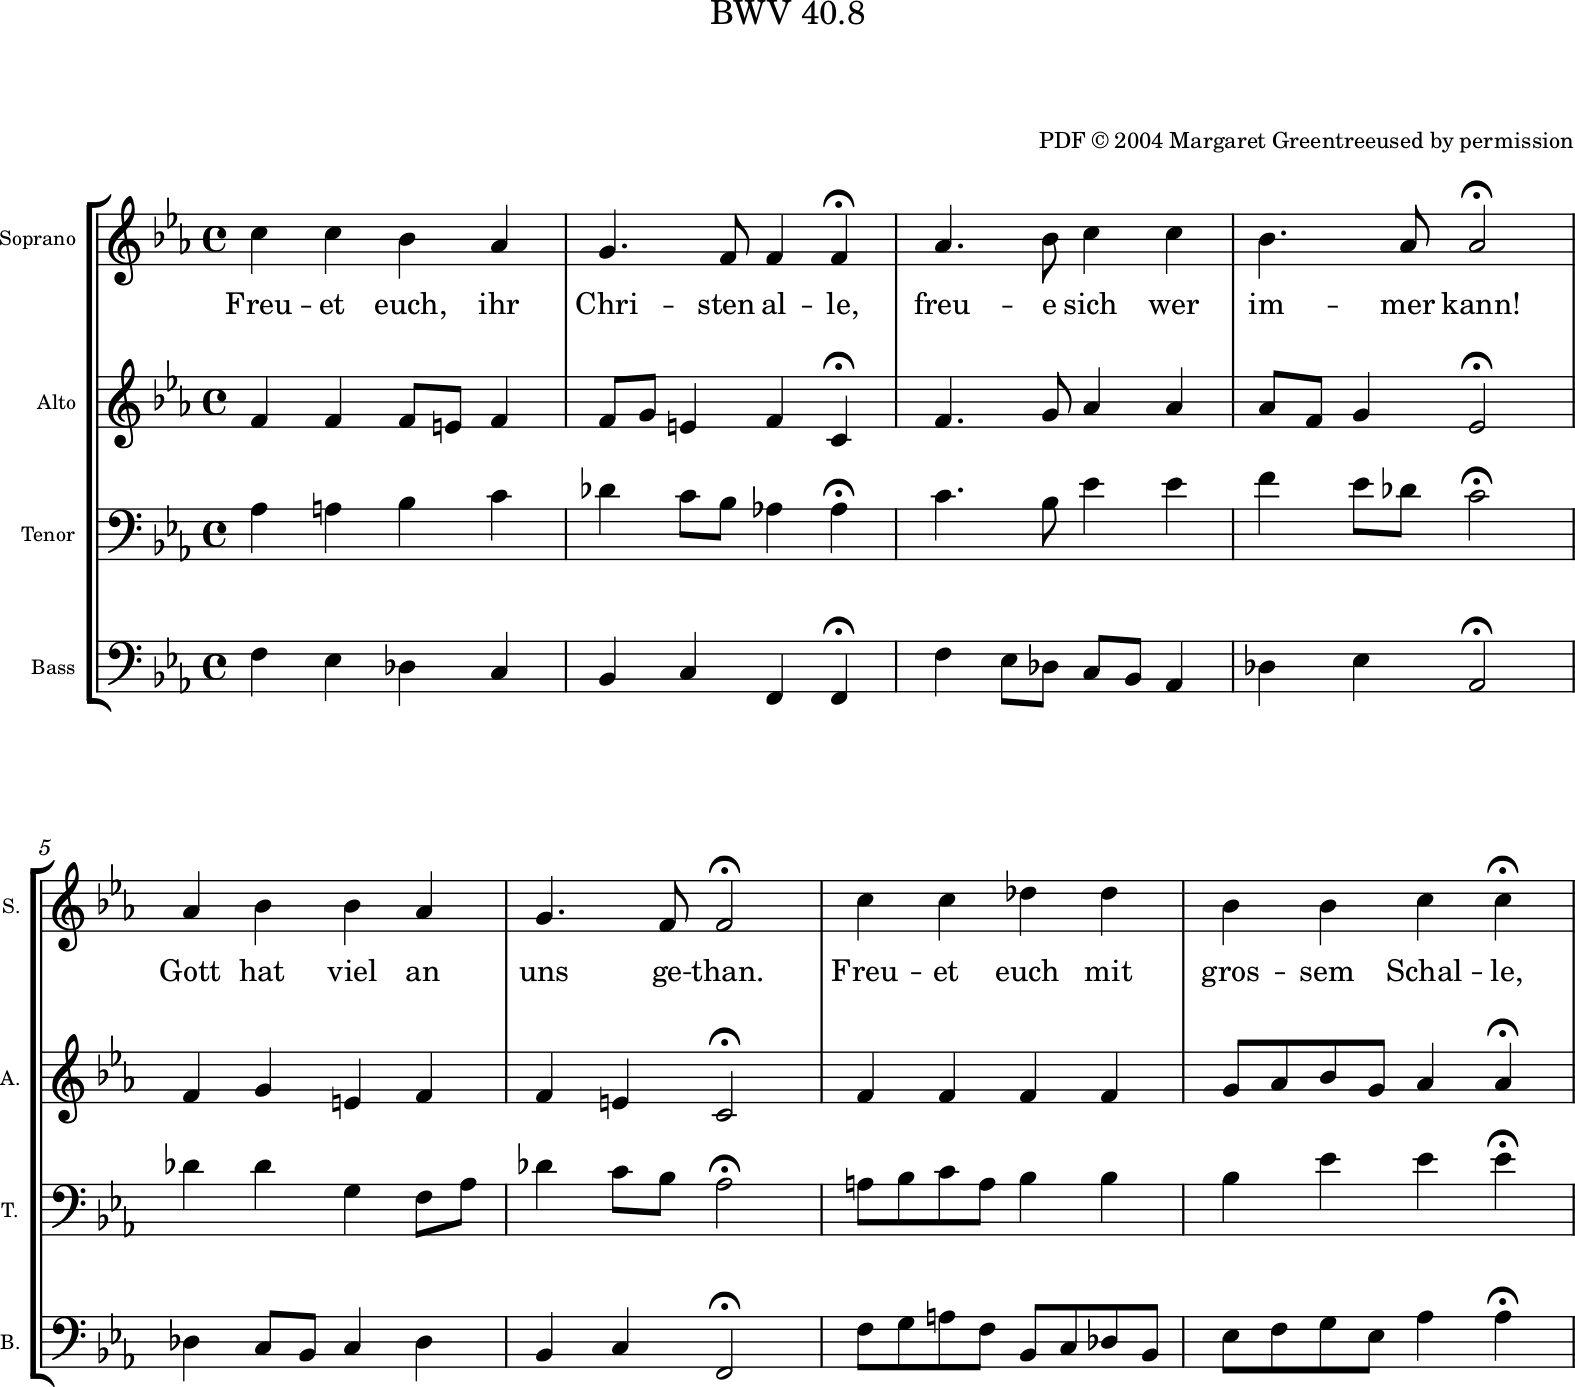

In [5]:
bach_score = corpus.parse('bwv40.8.mxl')
bach_score.show()

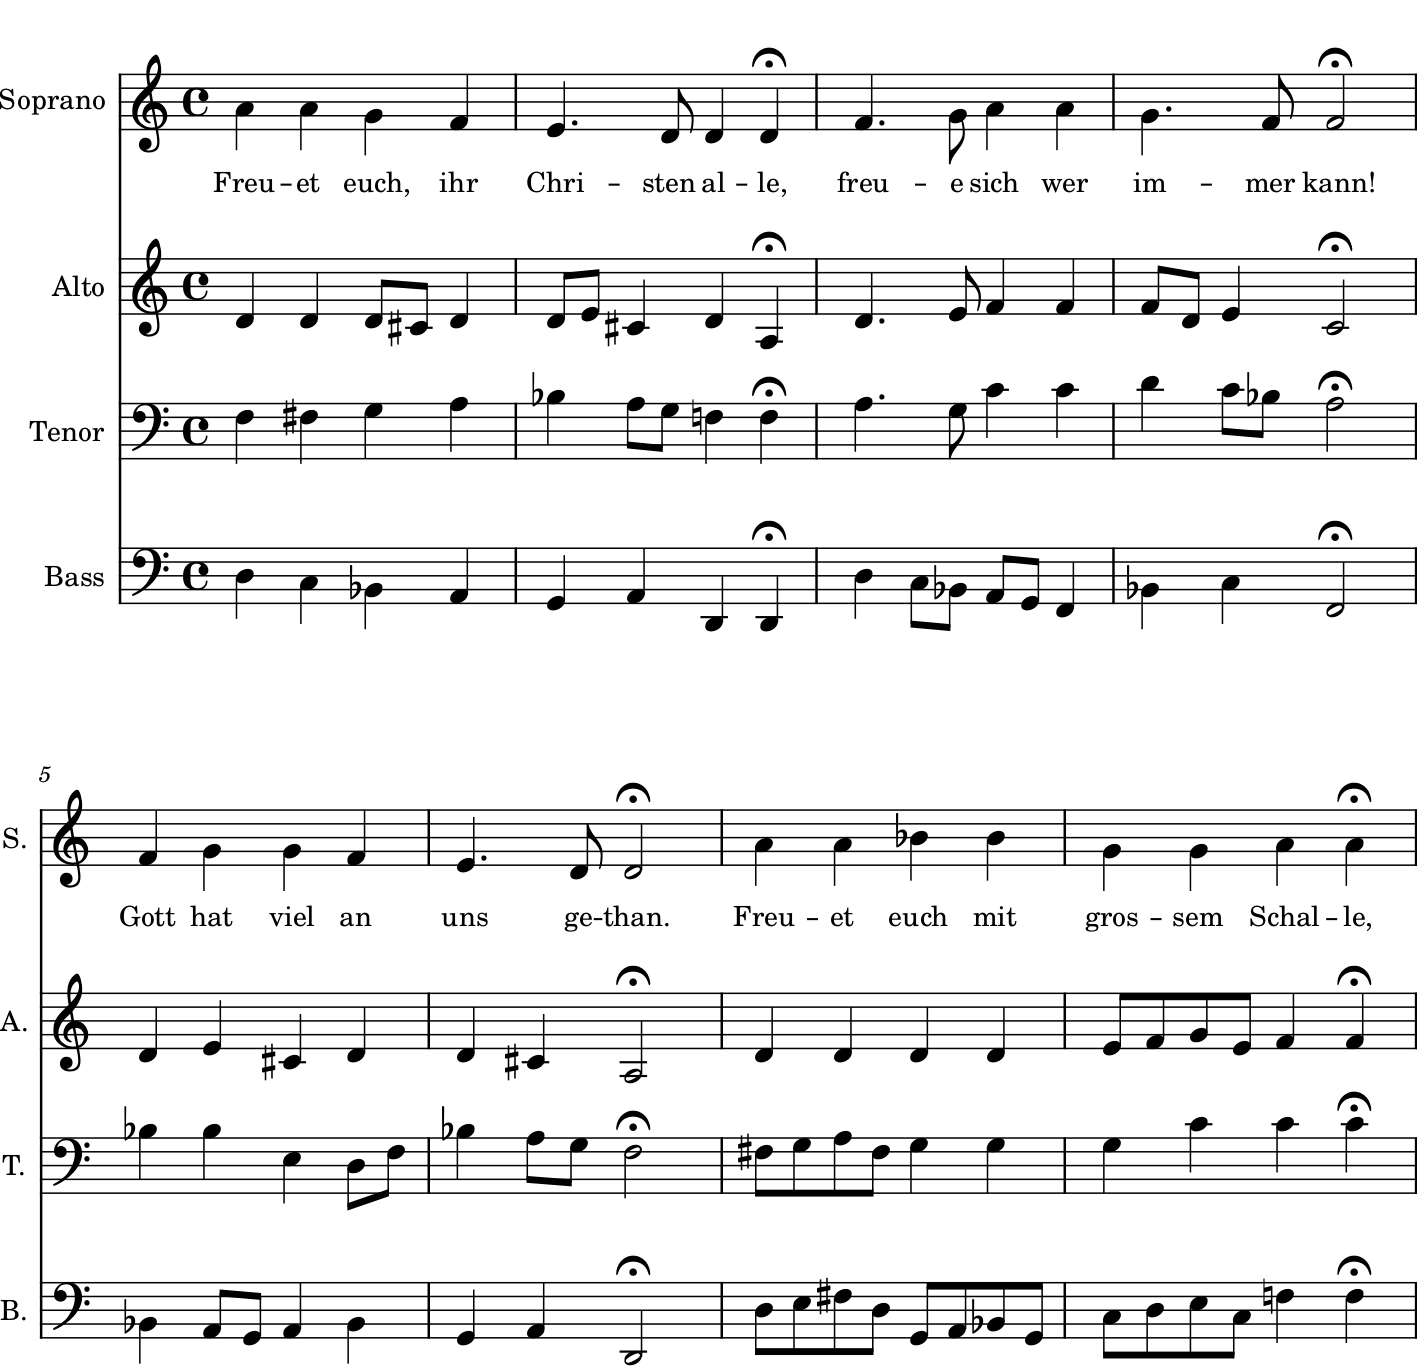

In [15]:
partnames=['Soprano','Alto','Tenor','Bass']
bach_score_transposed = Utils.transpose_score(bach_score, partnames, instruments=instruments)
bach_score_transposed.show()

In [34]:
steps_out_of_range = 11
if steps_out_of_range <0:
    tintval = interval.Interval('P8')
elif steps_out_of_range < 0:
    tintval = interval.Interval('P-8')
else:
    tintval = interval.Interval(0)
print(tintval.semitones)

0

In [59]:
steps_out_of_range = 19
print(divmod(steps_out_of_range, 12))    # x // y, x % y
noctaves = 1 + ( (abs(steps_out_of_range)-1) // 12)
semitones = 12 * noctaves
print(f"semitones: {semitones}")

(1, 7)
semitones: 24
